In [29]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline import CustomFactor
from quantopian.research import run_pipeline
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import SimpleMovingAverage  
from quantopian.pipeline.factors import Latest  
from operator import itemgetter 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.tsa.stattools as ts
from scipy import stats
import statsmodels
from statsmodels.tsa.stattools import coint
from sklearn import cluster, covariance, manifold


In [2]:
start_date = '2014-1-1'
end_date   = '2014-6-1'

In [3]:
# Get market cap and book-to-price for all assets in universe
fundamentals = init_fundamentals()
data = get_fundamentals(query(fundamentals.valuation.market_cap,
                              fundamentals.valuation_ratios.book_value_yield)
                            .filter(fundamentals.valuation.market_cap != None)
    .filter(fundamentals.valuation_ratios.book_value_yield != None), end_date).T

In [4]:
# Drop missing data
print data.head()
data.dropna(inplace=True)


                     market_cap  book_value_yield
Equity(2 [AA])     1.579070e+10            0.7179
Equity(21 [AAME])  7.382380e+07            1.3789
Equity(24 [AAPL])  5.082920e+11            0.2364
Equity(31 [ABAX])  9.034100e+08            0.2066
Equity(39 [DDC])   1.071720e+09            1.2172


In [5]:
# ignore assets with negative book-to-price
data = data.loc[data['book_value_yield'] > 0]

In [6]:
# Grab Sections in 10ths, since the data returned is too large for quantopian
market_cap_top = data.sort('market_cap')[9*len(data)/10:10*len(data)/10]

In [7]:
print market_cap_top

                          market_cap  book_value_yield
Equity(9514 [BWA])      1.420660e+10            0.2593
Equity(5479 [NTRS])     1.424800e+10            0.5579
Equity(32046 [QVCA])    1.426330e+10            0.4791
Equity(1795 [CPB])      1.427230e+10            0.0988
Equity(9883 [ATVI])     1.430710e+10            0.4840
Equity(5950 [PGR])      1.435610e+10            0.4485
Equity(2262 [DOV])      1.438460e+10            0.2606
Equity(39994 [NXPI])    1.439500e+10            0.0711
Equity(43920 [LMCB])    1.444840e+10            0.9787
Equity(6082 [PNR])      1.446440e+10            0.4104
Equity(32043 [QVCB])    1.447930e+10            0.4719
Equity(6546 [ROST])     1.449890e+10            0.1384
Equity(7684 [TSN])      1.462300e+10            0.4401
Equity(39095 [CHTR])    1.466740e+10            0.0087
Equity(3642 [HOT])      1.471660e+10            0.2254
Equity(22954 [ABC])     1.472020e+10            0.1458
Equity(15221 [SKM])     1.474280e+10            0.8848
Equity(394

In [8]:
returns = get_pricing(market_cap_top.index, fields='price',start_date=start_date, end_date=end_date).pct_change()[1:].dropna()

In [9]:
stocks = get_pricing(market_cap_top.index, fields='price',start_date=start_date, end_date=end_date)[1:].T.dropna()
stocks.head()

,2014-01-03 00:00:00+00:00,2014-01-06 00:00:00+00:00,2014-01-07 00:00:00+00:00,2014-01-08 00:00:00+00:00,2014-01-09 00:00:00+00:00,2014-01-10 00:00:00+00:00,2014-01-13 00:00:00+00:00,2014-01-14 00:00:00+00:00,2014-01-15 00:00:00+00:00,2014-01-16 00:00:00+00:00,...,2014-05-16 00:00:00+00:00,2014-05-19 00:00:00+00:00,2014-05-20 00:00:00+00:00,2014-05-21 00:00:00+00:00,2014-05-22 00:00:00+00:00,2014-05-23 00:00:00+00:00,2014-05-27 00:00:00+00:00,2014-05-28 00:00:00+00:00,2014-05-29 00:00:00+00:00,2014-05-30 00:00:00+00:00
Equity(9514 [BWA]),54.860,55.000,56.380,56.270,56.31,56.750,55.570,56.800,55.980,56.940,...,59.720,59.98,59.390,60.470,61.050,62.170,62.360,62.600,62.8301,62.900
Equity(5479 [NTRS]),61.310,60.910,61.700,62.020,61.49,61.120,60.420,60.590,61.190,61.070,...,59.830,60.08,59.580,59.880,60.300,60.360,60.830,60.770,60.4900,60.400
Equity(32046 [QVCA]),24.644,24.695,24.670,24.509,24.17,24.136,23.485,23.815,24.035,23.857,...,24.077,24.06,23.739,23.925,23.832,24.158,24.712,24.560,24.6440,24.657
Equity(1795 [CPB]),42.420,42.400,42.870,42.600,42.49,42.840,42.260,42.630,42.310,42.860,...,45.110,44.06,44.030,44.360,44.260,44.040,44.705,44.600,45.1500,45.890
Equity(9883 [ATVI]),18.300,18.080,18.315,18.335,18.30,18.185,17.865,17.495,17.380,17.330,...,20.355,20.78,20.835,20.870,20.540,20.680,20.580,20.325,20.7500,20.780


In [10]:
stocks = stocks.T
market_cap_top = market_cap_top.T
equities = market_cap_top.columns

In [11]:
# Learn a graphical structure from the correlations
edge_model = covariance.GraphLassoCV()

In [12]:
# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
iv = returns.T
iv.head()
variation = iv[:]
X = variation.copy().T

In [13]:
X /= X.std(axis=0)
edge_model.fit(X)

GraphLassoCV(alphas=4, assume_centered=False, cv=None, max_iter=100,
       mode='cd', n_jobs=1, n_refinements=4, tol=0.0001, verbose=False)

In [14]:
# Cluster using affinity propagation
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

In [15]:
v,v2 = list(),list()
for equity in equities.values:
    v.append(equity.security_name)
    v2.append(equity.symbol)

In [16]:
names = np.array(v).T
symbols = np.array(v2).T

In [17]:
print len(labels)

484


In [18]:
for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: NXP SEMICONDUCTOR NV, LIBERTY SPINCO INC, STARWOOD HOTELS & RESORTS WORLDWIDE  INC., PAYCHEX INC, FIDELITY NATIONAL INFORMATION SERVICES  INC., O'REILLY AUTOMOTIVE INC, WESTERN DIGITAL CORP, TEXAS INSTRUMENTS INC
Cluster 2: DAVITA HEALTHCARE PARTNERS INC, LINKEDIN CORP
Cluster 3: FASTENAL CO, EQT CORPORATION, LOEWS CORP, NOMURA HLDGS ADS ( 1 SH COM), BARCLAYS PLC ADS =4 ORDINARY U
Cluster 4: CHIPOLTE MEXICAN GRILL  INC. CL A, MICHAEL KORS HOLDINGS LTD, CIGNA CORP, AEGON NV -ORD-, DEVON ENERGY CORP (NEW), LIBERTY GLOBAL PLC, FEDEX CORPORATION, CAPITAL ONE FINANCIAL CORP
Cluster 5: SPECTRA ENERGY PARTNERS LP, CARNIVAL PLC ADS, VMWARE INC, NTT DOCOMO INC SPONS ADR, TOYOTA MOTOR CRP ADS (REP 2 SH
Cluster 6: ENERSIS AMERICA S.A., CHINA LIFE INSURANCE CO LTD ADS (REP 40 H SHS)
Cluster 7: ANALOG DEVICES INC, COCA-COLA FEMSA SA DE CV ADS, WIPRO LIMITED ADS (1 EQTY SHS)
Cluster 8: TRANSOCEAN LTD, GRUPO FINANCIERO SANTANDER MEXICO SAB DE CV
Cluster 9: MOTOROLA SOLUTIONS INC, SONY CORP

In [19]:
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

(-0.17338443732049794, 0.25326842356283108)

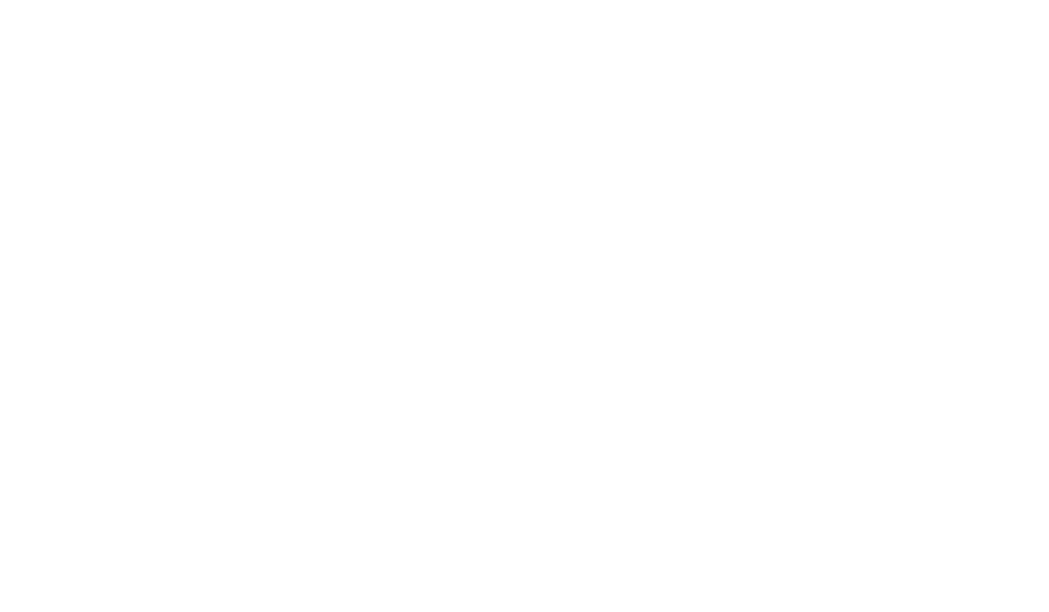

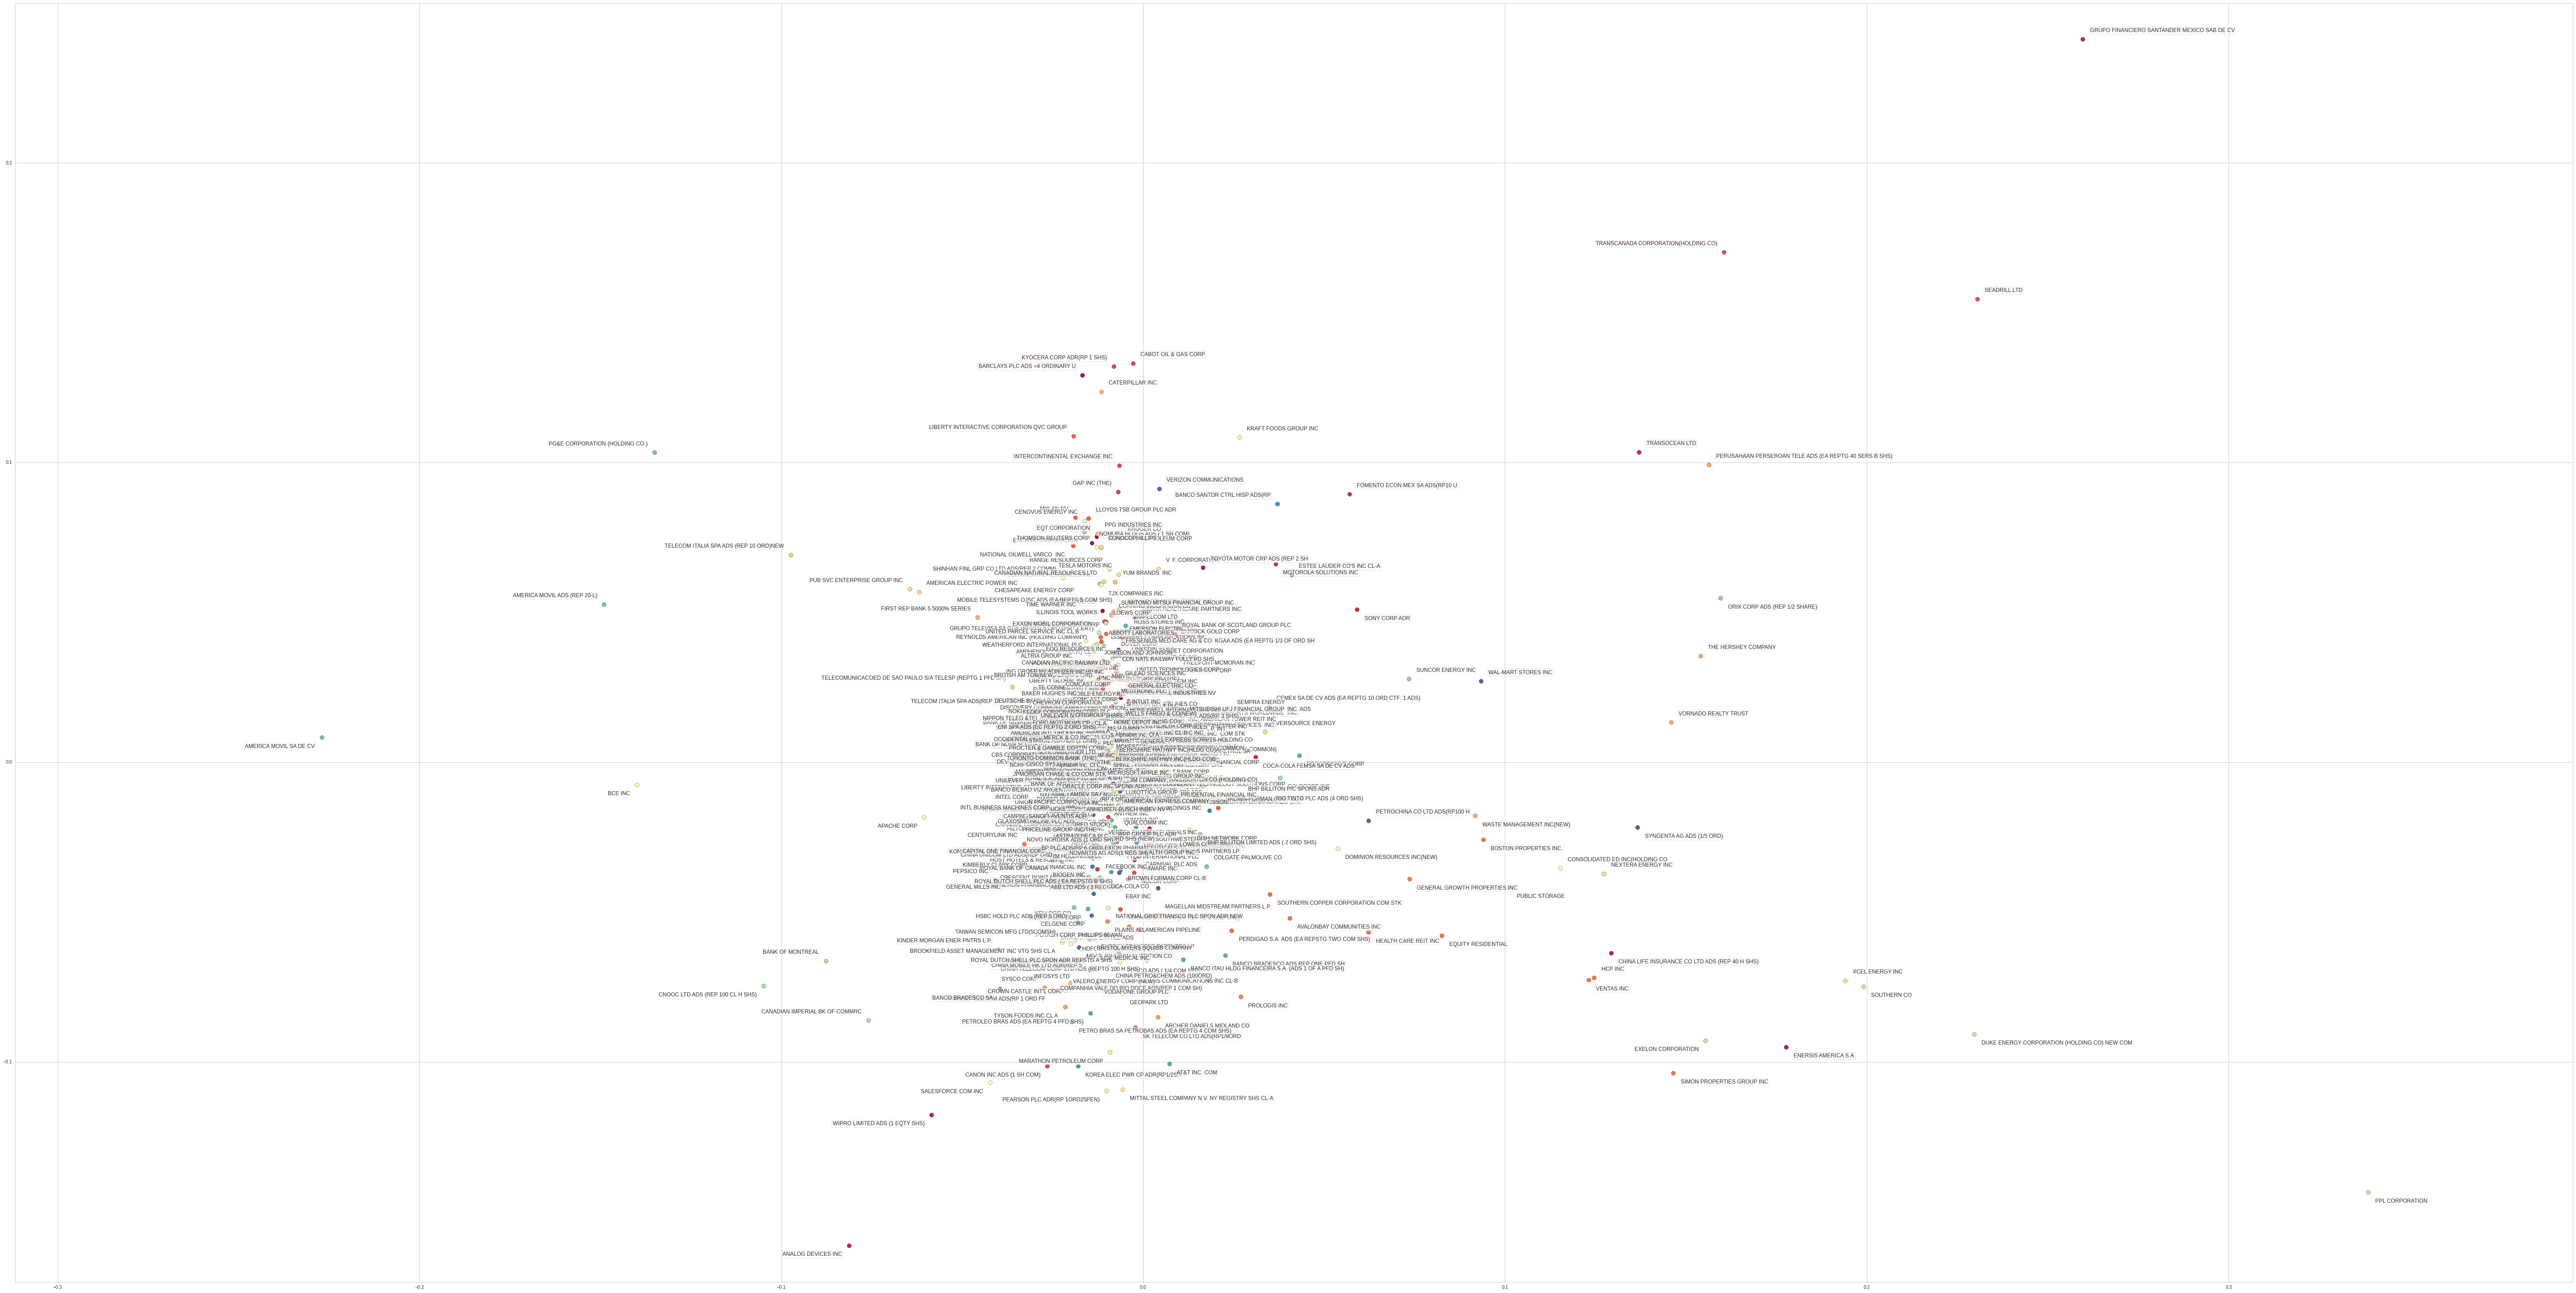

In [20]:
# Visualization
plt.figure(1, facecolor='w')
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')
plt.figure(figsize=(100,50))
# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.get_cmap('Spectral'))

# Plot the edges
start_idx, end_idx = np.where(non_zero)

segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]

values = np.abs(partial_correlations[non_zero])

#lc = matplotlib.collections.LineCollection(segments,
#                    zorder=0, cmap=plt.cm.hot_r,
#                    norm=plt.Normalize(0, .7 * values.max()))
# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=12,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.get_cmap('Spectral')(label / float(n_labels)),
                       alpha=.6))
    
plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

In [21]:
def average_ratio(X,Y):
    return np.sum(Y/X)/len(X)

def moving_average_ratio(kappa,average_ratio,X,Y):
    m_a_ratio = []
    m_a_ratio.append(average_ratio)
    for i in range(1,len(X)):
        m_a_ratio.append((1-kappa)*m_a_ratio[i-1] + kappa*(Y[i]/X[i]))
    return m_a_ratio

start = '1-1-2014'
end   = '1-1-2015'
stocks = []
plt.figure()
for i in range(n_labels + 1):
    ii = -1
    zz = [labels==i]
    stocks_used = list()
    stocks_found = list()
    for every in zz[0]:
        ii += 1
        if every:
            stocks_used.append(ii)
    for iii in range(0,len(stocks_used)):
        X = get_pricing(returns.columns[stocks_used[iii]], start_date=start, end_date=end, frequency='daily')
        for iiii in range(iii+1,len(stocks_used)):
            Y = get_pricing(returns.columns[stocks_used[iiii]], start_date=start, end_date=end, frequency='daily')
            score, pvalue, _ = coint(X['price'],Y['price'])
            #Lets check Dicky Fuller Test, first lets try to generate a stationary process. 
            average_ratio_ = average_ratio(X['price'],Y['price'])
            v = Y['price']-average_ratio_*X['price']
            v = v.dropna()
            try:
                _,ad_fuller_pvalue,_,_,_,_=ts.adfuller(v, 1)
                if pvalue < 0.05 and ad_fuller_pvalue < 0.05:
                    print(symbols[stocks_used[iii]],symbols[stocks_used[iiii]])
                    stocks.append((symbols[stocks_used[iii]],symbols[stocks_used[iiii]]))
            except:
                v = None

(u'TI_A', u'VIV')
(u'SHW', u'NOC')
(u'FCX', u'HAL')
(u'NTRS', u'EMC')
(u'STZ', u'KMI')
(u'AET', u'CB')
(u'WPPG_Y', u'PCP')
(u'AGN', u'LLY')
(u'MRK', u'BUD')
(u'BSX', u'PX')
(u'BSX', u'MON')
(u'BSX', u'BA')
(u'DLPH', u'MON')
(u'VIA', u'VIAB')
(u'NOK', u'ECL')
(u'NOK', u'MCK')
(u'CBS', u'CBS_A')
(u'ASML', u'MCK')
(u'ASML', u'BLK')
(u'MCK', u'BLK')
(u'MCK', u'SBUX')
(u'TEVA', u'MS')
(u'AMOV', u'AMX')
(u'FOX', u'HON')
(u'FOXA', u'HON')
(u'ARMH', u'AZN')
(u'PBR', u'PBR_A')
(u'MU', u'COV')
(u'BRK_B', u'BRK_A')


In [22]:
for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(symbols[labels == i])))

Cluster 1: NXPI, LMCB, HOT, PAYX, FIS, ORLY, WDC, TXN
Cluster 2: DVA, LNKD
Cluster 3: FAST, EQT, L, NMR, BCS
Cluster 4: CMG, KORS, CI, AEG, DVN, LBTY_A, FDX, COF
Cluster 5: SEP, CUK, VMW, DCM, TM
Cluster 6: ENI, LFC
Cluster 7: ADI, KOF, WIT
Cluster 8: RIG, BSMX
Cluster 9: MSI, SNE, EL, FMX, RBS
Cluster 10: HST, BBDO, VALE
Cluster 11: CPG, CRH, BNS
Cluster 12: CHTR, LMCA, ZBH, CAJ, ABBV
Cluster 13: COG, KYO, GPS, ICE
Cluster 14: NUE, TTM, ABB, NVO
Cluster 15: DOV, APH, HIG, ROK, WFM, JCI, TWC, EMR, UTX, CMCS_K, CMCS_A, C, GE
Cluster 16: SDRL, SWN, TRP
Cluster 17: PAGP, CB, ETE, DE, ITW, DB, PUK
Cluster 18: SKM, MMP, BF_A, TS
Cluster 19: ATVI, QVCB, AR, MYL, CHK, NOV, ABT, LYG
Cluster 20: BRCM
Cluster 21: TV, KMP
Cluster 22: AVB, BXP, HCN, HCP, VTR, BRFS, EQR, SCCO, SPG
Cluster 23: CTL
Cluster 24: GGP
Cluster 25: PLD
Cluster 26: ETP, MPEL, PAA, POT
Cluster 27: FITB, STI, STT, MFC, PRU, BK, PNC, MET, EC, DIS
Cluster 28: DISC_B, M, CP, PXD, SMFG, HD
Cluster 29: TSN, SYY, ADM
Cluster 30: VN

Equity(6119 [PPL])
Equity(22114 [EXC])
Equity(7011 [SO])
Equity(2351 [DUK])


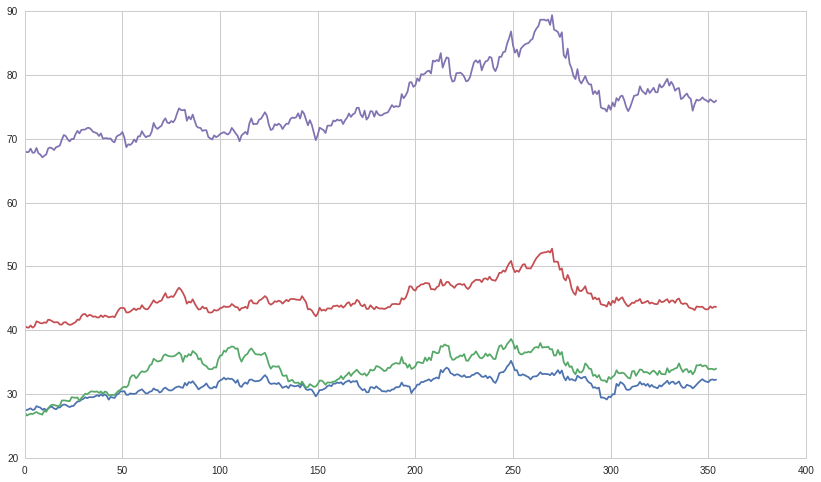

In [61]:
# Take a look at how a cluster performed, based on an out of sample selection (next 6 months)
start = '1-1-2014'
end   = '6-1-2015'
plt.figure()
# for i in range(12):#n_labels + 1):
i = 66
ii = -1
zz = [labels==i]
for every in zz[0]:
    ii += 1
    if every:
        prices = get_pricing(returns.columns[ii], start_date=start, end_date=end, frequency='daily')
        plt.plot(prices['close_price'])
        print returns.columns[ii]

(u'ASML', u'MCK')


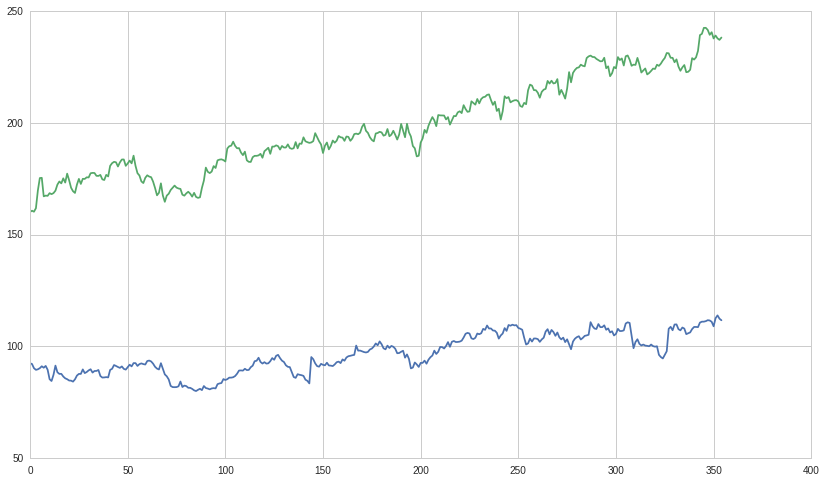

In [137]:
# Take a look at how a pair performed, based on an out of sample selection (next 6 months)
start = '1-1-2014'
end   = '6-1-2015'
plt.figure()
i = 17
pair = stocks[i]
print(pair)
prices = get_pricing(pair, start_date=start, end_date=end, frequency='daily')
plt.plot(prices['close_price'])

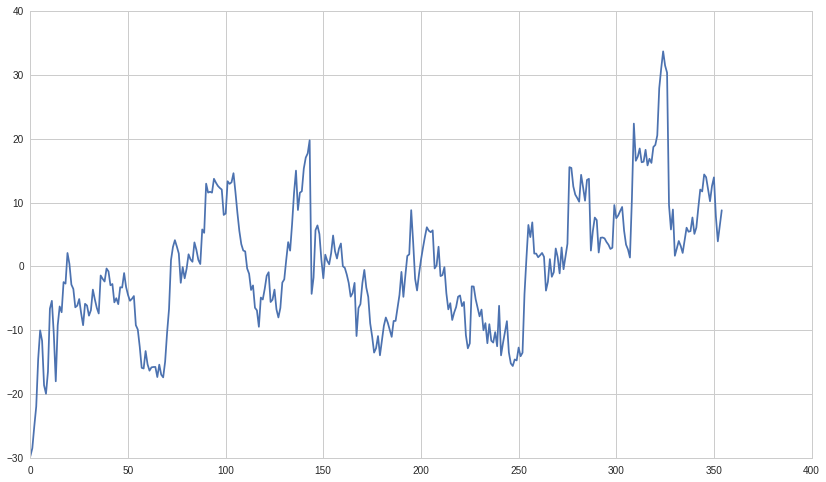

In [136]:
# Take a look at how a pair performed, based on an out of sample selection (next 6 months)
start = '1-1-2014'
end   = '6-1-2015'
i = 17

pair = stocks[i]
prices = get_pricing(pair, start_date=start, end_date=end, frequency='daily')
X = prices['close_price'][prices['close_price'].columns[0]]
Y = prices['close_price'][prices['close_price'].columns[1]]
average_ratio_ = average_ratio(X,Y)
plt.plot(Y-average_ratio_*X)